# 04. 비즈니스 인사이트 & 제언

모델 분석 결과를 HR 담당자 관점에서 해석하고, 실행 가능한 리텐션 전략을 제안한다.

**구성:**
1. 피처 중요도 — 퇴사를 결정짓는 핵심 요인
2. 주요 퇴사 요인 심층 분석
3. 퇴사 위험군 프로파일링
4. 비용 영향 분석 & ROI 시뮬레이션
5. HR 부서별 맞춤 제언
6. 한계점 및 향후 과제

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

from src.data_loader import load_raw_data, PROCESSED_DIR

plt.rcParams['font.family'] = 'Apple SD Gothic Neo'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)
sns.set_theme(style='whitegrid', font='Apple SD Gothic Neo')

COLORS_RISK = {'고위험': '#E74C3C', '중위험': '#F39C12', '저위험': '#27AE60'}

%matplotlib inline

## 4.1 데이터 로드

In [2]:
# 원본 데이터 (비즈니스 해석용 — 인코딩 전 범주 레이블 필요)
raw = load_raw_data()
raw = raw.drop(columns=['EmployeeCount', 'StandardHours', 'Over18'])

# 피처 중요도
feat_imp = pd.read_csv(PROCESSED_DIR / 'feature_importance.csv')

# 예측 확률 & 위험도
predictions = pd.read_csv(PROCESSED_DIR / 'predictions.csv')

# 원본 + 예측 결합
raw['Predict_Prob'] = predictions['Predict_Prob'].values
raw['Risk_Level'] = predictions['Risk_Level'].values

# 모델 비교 결과
model_comp = pd.read_csv(PROCESSED_DIR / 'model_comparison.csv', index_col=0)

print(f"분석 대상: {raw.shape[0]}명")
print(f"\n위험도 분포:")
print(raw['Risk_Level'].value_counts().to_string())

분석 대상: 1470명

위험도 분포:
Risk_Level
저위험    1168
고위험     225
중위험      77


## 4.2 피처 중요도 — 퇴사를 결정짓는 핵심 요인

모델이 학습한 피처 중요도를 비즈니스 카테고리로 분류하여 해석한다.

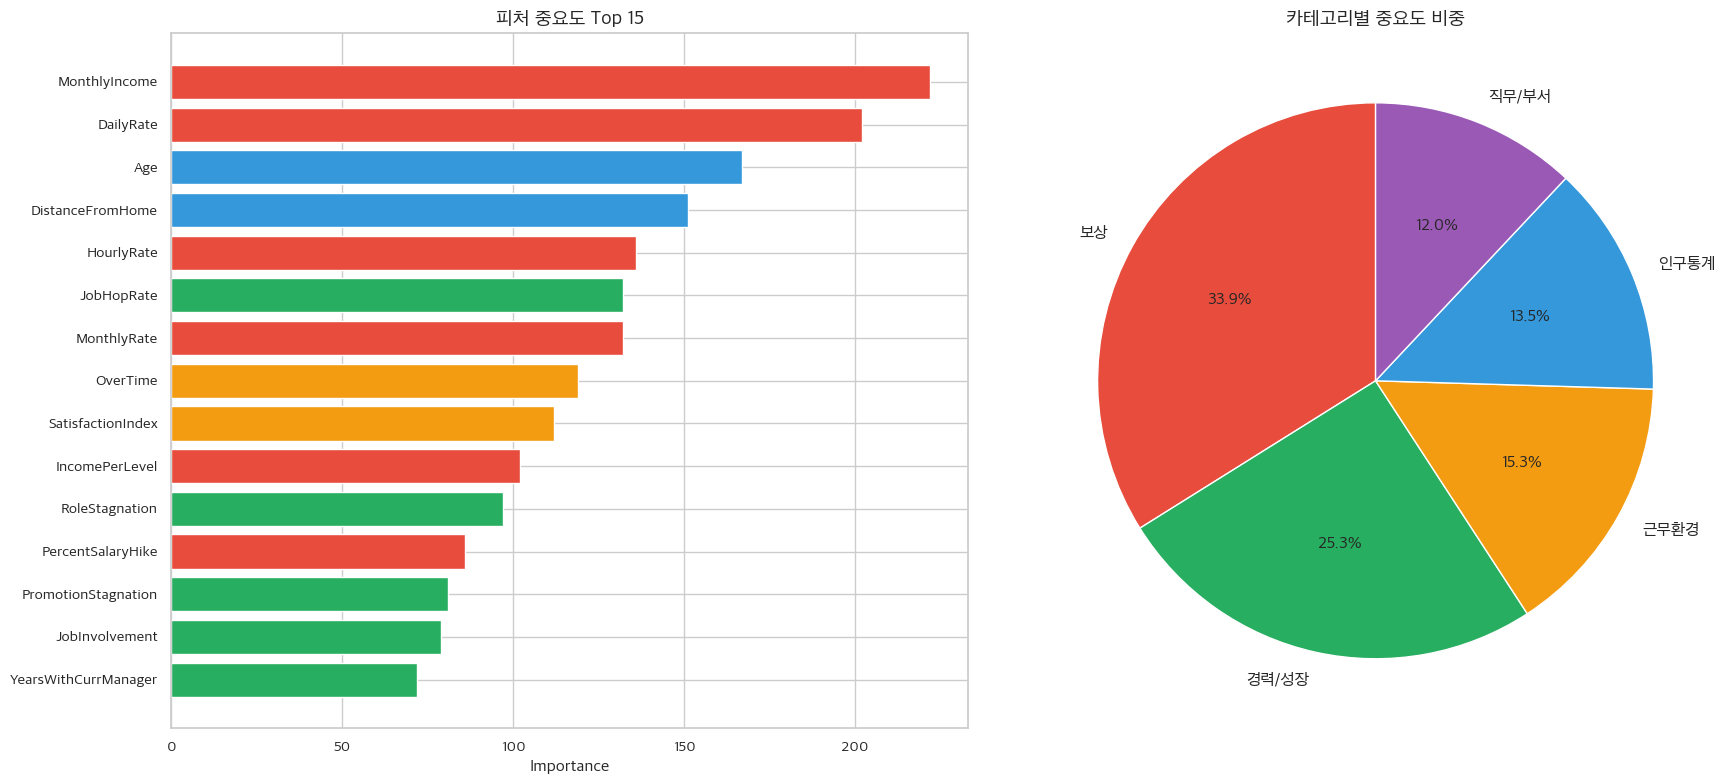

카테고리별 중요도 합산:
  보상        : 33.9%
  경력/성장     : 25.3%
  근무환경      : 15.3%
  인구통계      : 13.5%
  직무/부서     : 12.0%


In [3]:
# 피처를 비즈니스 카테고리로 분류
category_map = {
    # 보상
    'MonthlyIncome': '보상', 'DailyRate': '보상', 'HourlyRate': '보상',
    'MonthlyRate': '보상', 'PercentSalaryHike': '보상',
    'StockOptionLevel': '보상', 'IncomePerLevel': '보상',
    # 인구통계
    'Age': '인구통계', 'Gender': '인구통계', 'DistanceFromHome': '인구통계',
    'Education': '인구통계',
    # 근무환경
    'OverTime': '근무환경', 'EnvironmentSatisfaction': '근무환경',
    'JobSatisfaction': '근무환경', 'RelationshipSatisfaction': '근무환경',
    'WorkLifeBalance': '근무환경', 'SatisfactionIndex': '근무환경',
    # 경력/성장
    'TotalWorkingYears': '경력/성장', 'YearsAtCompany': '경력/성장',
    'YearsInCurrentRole': '경력/성장', 'YearsWithCurrManager': '경력/성장',
    'YearsSinceLastPromotion': '경력/성장', 'NumCompaniesWorked': '경력/성장',
    'TrainingTimesLastYear': '경력/성장', 'JobInvolvement': '경력/성장',
    'PerformanceRating': '경력/성장',
    'PromotionStagnation': '경력/성장', 'RoleStagnation': '경력/성장',
    'JobHopRate': '경력/성장',
}

feat_imp['category'] = feat_imp['feature'].map(
    lambda x: category_map.get(x, '직무/부서')
)

# 카테고리별 중요도 합산
cat_imp = feat_imp.groupby('category')['importance'].sum().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 좌: 개별 피처 Top 15
top15 = feat_imp.head(15).sort_values('importance', ascending=True)
cat_colors = {'보상': '#E74C3C', '인구통계': '#3498DB', '근무환경': '#F39C12',
              '경력/성장': '#27AE60', '직무/부서': '#9B59B6'}
bar_colors = [cat_colors.get(c, '#95A5A6') for c in top15['category']]
axes[0].barh(top15['feature'], top15['importance'], color=bar_colors)
axes[0].set_title('피처 중요도 Top 15', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Importance')

# 우: 카테고리별 합산
cat_colors_list = [cat_colors.get(c, '#95A5A6') for c in cat_imp.index]
axes[1].pie(cat_imp, labels=cat_imp.index, autopct='%1.1f%%',
            colors=cat_colors_list, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('카테고리별 중요도 비중', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/figures/13_feature_importance_business.png', dpi=150, bbox_inches='tight')
plt.show()

print("카테고리별 중요도 합산:")
for cat, imp in cat_imp.items():
    pct = imp / cat_imp.sum() * 100
    print(f"  {cat:10s}: {pct:.1f}%")

### 피처 중요도 해석

| 순위 | 카테고리 | 핵심 발견 | HR 시사점 |
|------|---------|----------|----------|
| 1 | **보상** | MonthlyIncome, DailyRate가 최상위 | 급여 경쟁력이 가장 중요한 리텐션 레버 |
| 2 | **인구통계** | Age, DistanceFromHome 높은 중요도 | 젊은 층, 원거리 통근자 주의 |
| 3 | **근무환경** | OverTime, SatisfactionIndex | 야근 관리와 만족도 향상이 핵심 |
| 4 | **경력/성장** | JobHopRate, 근속 관련 변수 | 이직 빈도 높은 직원, 성장 정체 주의 |

## 4.3 주요 퇴사 요인 심층 분석

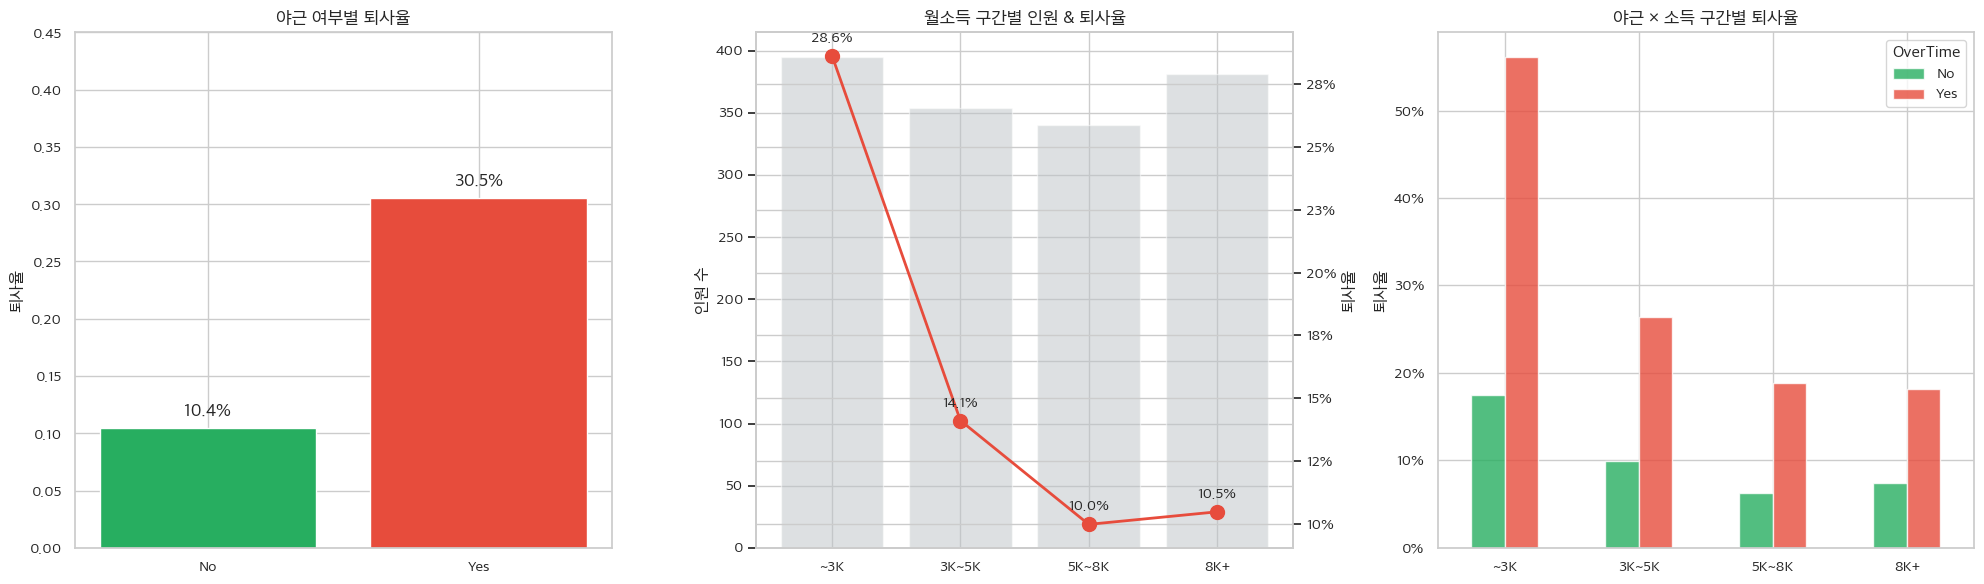

In [4]:
# 4.3.1 야근 × 소득 × 퇴사 — 가장 강력한 요인 조합
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 야근별 퇴사율
ot_rates = raw.groupby('OverTime')['Attrition'].apply(lambda x: (x == 'Yes').mean())
colors_ot = ['#27AE60', '#E74C3C']
bars = axes[0].bar(ot_rates.index, ot_rates.values, color=colors_ot)
for bar, rate in zip(bars, ot_rates.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, rate + 0.01,
                 f'{rate:.1%}', ha='center', fontsize=13, fontweight='bold')
axes[0].set_title('야근 여부별 퇴사율', fontsize=13, fontweight='bold')
axes[0].set_ylabel('퇴사율')
axes[0].set_ylim(0, 0.45)

# 소득 구간별 퇴사율
raw['IncomeBand'] = pd.cut(raw['MonthlyIncome'],
                           bins=[0, 3000, 5000, 8000, 20000],
                           labels=['~3K', '3K~5K', '5K~8K', '8K+'])
inc_rates = raw.groupby('IncomeBand', observed=True)['Attrition'].apply(
    lambda x: (x == 'Yes').mean())
inc_counts = raw.groupby('IncomeBand', observed=True).size()

ax2 = axes[1].twinx()
axes[1].bar(range(len(inc_rates)), inc_counts, color='#BDC3C7', alpha=0.5, label='인원 수')
ax2.plot(range(len(inc_rates)), inc_rates.values, 'o-', color='#E74C3C',
         linewidth=2, markersize=10, label='퇴사율')
axes[1].set_xticks(range(len(inc_rates)))
axes[1].set_xticklabels(inc_rates.index)
axes[1].set_title('월소득 구간별 인원 & 퇴사율', fontsize=13, fontweight='bold')
axes[1].set_ylabel('인원 수')
ax2.set_ylabel('퇴사율')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
for i, rate in enumerate(inc_rates.values):
    ax2.annotate(f'{rate:.1%}', (i, rate), textcoords="offset points",
                 xytext=(0, 10), ha='center', fontsize=11, fontweight='bold')

# 야근 × 소득 교차
cross = raw.pivot_table(index='IncomeBand', columns='OverTime',
                        values='Attrition', aggfunc=lambda x: (x == 'Yes').mean(),
                        observed=True)
cross.plot(kind='bar', ax=axes[2], color=['#27AE60', '#E74C3C'], alpha=0.8)
axes[2].set_title('야근 × 소득 구간별 퇴사율', fontsize=13, fontweight='bold')
axes[2].set_ylabel('퇴사율')
axes[2].set_xlabel('')
axes[2].legend(title='OverTime')
axes[2].tick_params(axis='x', rotation=0)
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

plt.tight_layout()
plt.savefig('../outputs/figures/14_overtime_income_attrition.png', dpi=150, bbox_inches='tight')
plt.show()

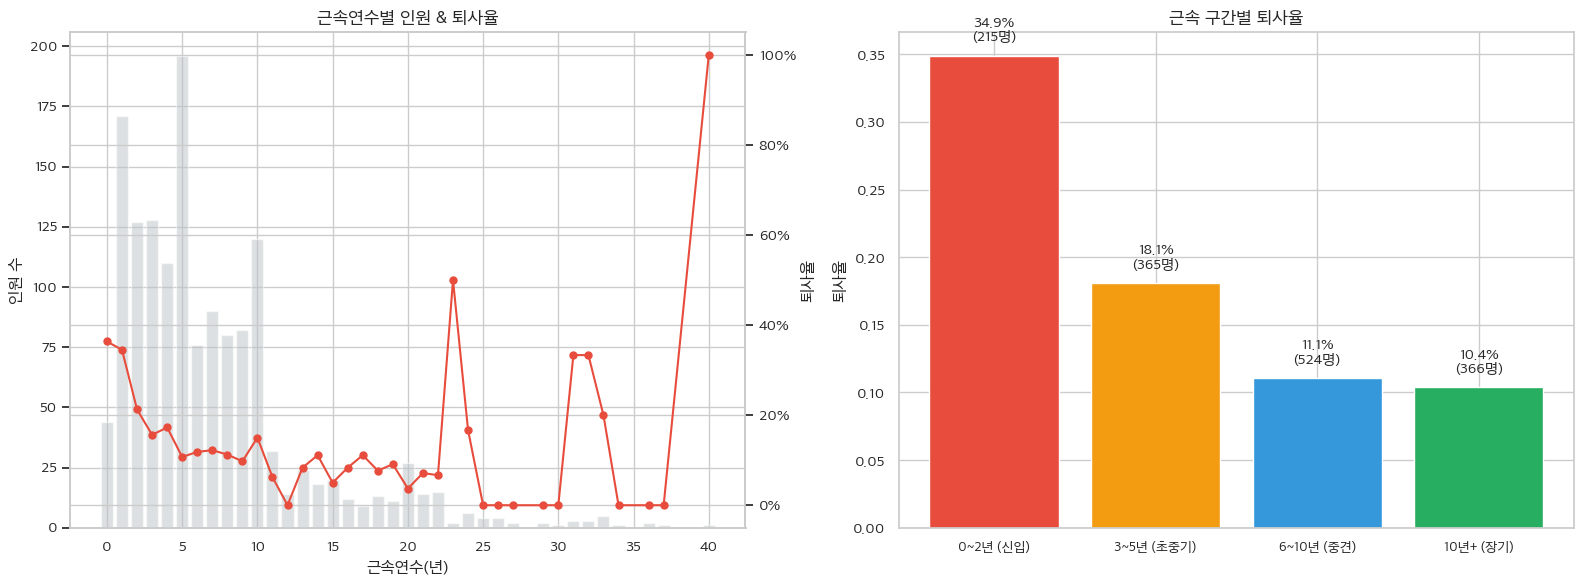

→ 입사 0~2년 퇴사율이 가장 높음: 채용/온보딩 투자가 회수되기 전에 이탈


In [5]:
# 4.3.2 근속연수별 퇴사 패턴 — "언제 떠나는가"
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 근속연수별 퇴사율
tenure_rates = raw.groupby('YearsAtCompany')['Attrition'].apply(
    lambda x: (x == 'Yes').mean())
tenure_counts = raw.groupby('YearsAtCompany').size()

ax2 = axes[0].twinx()
axes[0].bar(tenure_rates.index, tenure_counts, color='#BDC3C7', alpha=0.5)
ax2.plot(tenure_rates.index, tenure_rates.values, 'o-', color='#E74C3C',
         linewidth=1.5, markersize=5)
axes[0].set_title('근속연수별 인원 & 퇴사율', fontsize=13, fontweight='bold')
axes[0].set_xlabel('근속연수(년)')
axes[0].set_ylabel('인원 수')
ax2.set_ylabel('퇴사율')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# 근속 구간별 요약
bins = [0, 2, 5, 10, 41]
labels_t = ['0~2년 (신입)', '3~5년 (초중기)', '6~10년 (중견)', '10년+ (장기)']
raw['TenureBand'] = pd.cut(raw['YearsAtCompany'], bins=bins, labels=labels_t, right=False)
tb_rates = raw.groupby('TenureBand', observed=True)['Attrition'].apply(
    lambda x: (x == 'Yes').mean())
tb_counts = raw.groupby('TenureBand', observed=True).size()

colors_tb = ['#E74C3C', '#F39C12', '#3498DB', '#27AE60']
bars = axes[1].bar(range(len(tb_rates)), tb_rates.values, color=colors_tb)
for bar, rate, cnt in zip(bars, tb_rates.values, tb_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, rate + 0.01,
                 f'{rate:.1%}\n({cnt}명)', ha='center', fontsize=11)
axes[1].set_xticks(range(len(tb_rates)))
axes[1].set_xticklabels(labels_t, fontsize=10)
axes[1].set_title('근속 구간별 퇴사율', fontsize=13, fontweight='bold')
axes[1].set_ylabel('퇴사율')

plt.tight_layout()
plt.savefig('../outputs/figures/15_tenure_attrition.png', dpi=150, bbox_inches='tight')
plt.show()

print("→ 입사 0~2년 퇴사율이 가장 높음: 채용/온보딩 투자가 회수되기 전에 이탈")

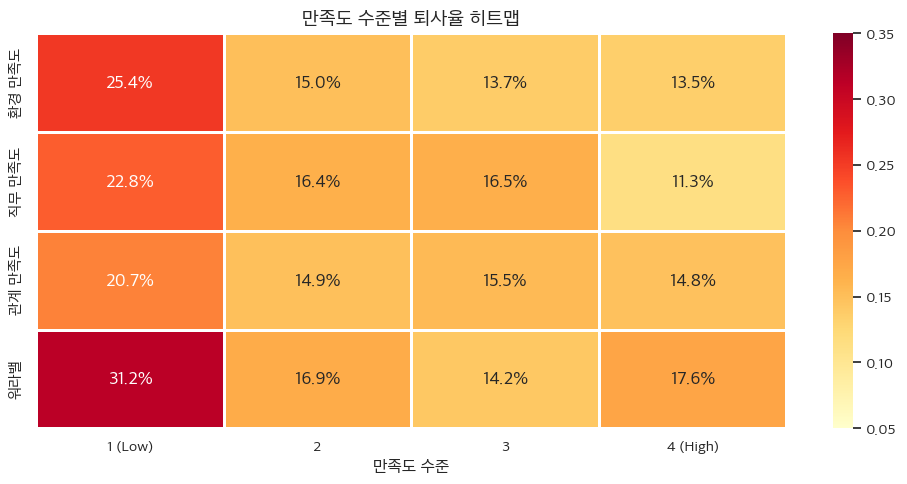

→ 모든 만족도 항목에서 1(Low)일 때 퇴사율이 뚜렷하게 높음
→ 특히 워라밸=1(31.2%), 직무몰입도=1(33.7%)이 가장 위험


In [6]:
# 4.3.3 만족도 히트맵 — "무엇에 불만인가"
sat_cols = ['EnvironmentSatisfaction', 'JobSatisfaction',
            'RelationshipSatisfaction', 'WorkLifeBalance']
sat_labels = ['환경 만족도', '직무 만족도', '관계 만족도', '워라밸']

# 만족도별 퇴사율 매트릭스
sat_matrix = pd.DataFrame(index=['1 (Low)', '2', '3', '4 (High)'])
for col, label in zip(sat_cols, sat_labels):
    rates = raw.groupby(col)['Attrition'].apply(lambda x: (x == 'Yes').mean())
    sat_matrix[label] = rates.values

fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(sat_matrix.T, annot=True, fmt='.1%', cmap='YlOrRd',
            linewidths=1, ax=ax, vmin=0.05, vmax=0.35,
            annot_kws={'fontsize': 13})
ax.set_title('만족도 수준별 퇴사율 히트맵', fontsize=14, fontweight='bold')
ax.set_xlabel('만족도 수준')

plt.tight_layout()
plt.savefig('../outputs/figures/16_satisfaction_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("→ 모든 만족도 항목에서 1(Low)일 때 퇴사율이 뚜렷하게 높음")
print("→ 특히 워라밸=1(31.2%), 직무몰입도=1(33.7%)이 가장 위험")

## 4.4 퇴사 위험군 프로파일링

모델 예측 확률을 기반으로 직원을 3단계 위험군으로 분류하고, 각 그룹의 특성을 비교한다.
- **고위험** (60%+): 즉시 개입 필요
- **중위험** (30~60%): 모니터링 & 예방적 개입
- **저위험** (~30%): 유지 전략

In [7]:
# 위험군별 주요 특성 비교
profile_cols = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'TotalWorkingYears',
                'DistanceFromHome', 'NumCompaniesWorked']

profile = raw.groupby('Risk_Level')[profile_cols].agg(['mean', 'median']).round(1)

print("위험군별 프로파일 (평균 / 중앙값):")
print("=" * 80)
for risk in ['고위험', '중위험', '저위험']:
    n = (raw['Risk_Level'] == risk).sum()
    actual_rate = raw[raw['Risk_Level'] == risk]['Attrition'].apply(
        lambda x: x == 'Yes').mean()
    print(f"\n[{risk}] {n}명 (실제 퇴사율: {actual_rate:.1%})")
    for col in profile_cols:
        mean_val = profile.loc[risk, (col, 'mean')]
        med_val = profile.loc[risk, (col, 'median')]
        print(f"  {col:25s}: 평균 {mean_val:>8.1f}  |  중앙값 {med_val:>8.1f}")

위험군별 프로파일 (평균 / 중앙값):

[고위험] 225명 (실제 퇴사율: 12.9%)
  Age                      : 평균     37.4  |  중앙값     36.0
  MonthlyIncome            : 평균   7127.6  |  중앙값   5228.0
  YearsAtCompany           : 평균      7.2  |  중앙값      5.0
  TotalWorkingYears        : 평균     11.8  |  중앙값     10.0
  DistanceFromHome         : 평균      8.5  |  중앙값      7.0
  NumCompaniesWorked       : 평균      2.7  |  중앙값      1.0

[중위험] 77명 (실제 퇴사율: 10.4%)
  Age                      : 평균     37.1  |  중앙값     35.0
  MonthlyIncome            : 평균   6541.8  |  중앙값   4558.0
  YearsAtCompany           : 평균      8.0  |  중앙값      6.0
  TotalWorkingYears        : 평균     11.1  |  중앙값      9.0
  DistanceFromHome         : 평균      8.5  |  중앙값      6.0
  NumCompaniesWorked       : 평균      2.4  |  중앙값      1.0

[저위험] 1168명 (실제 퇴사율: 17.1%)
  Age                      : 평균     36.8  |  중앙값     36.0
  MonthlyIncome            : 평균   6380.0  |  중앙값   4877.5
  YearsAtCompany           : 평균      6.9  |  중앙값      5.0
  TotalWorkingYears     

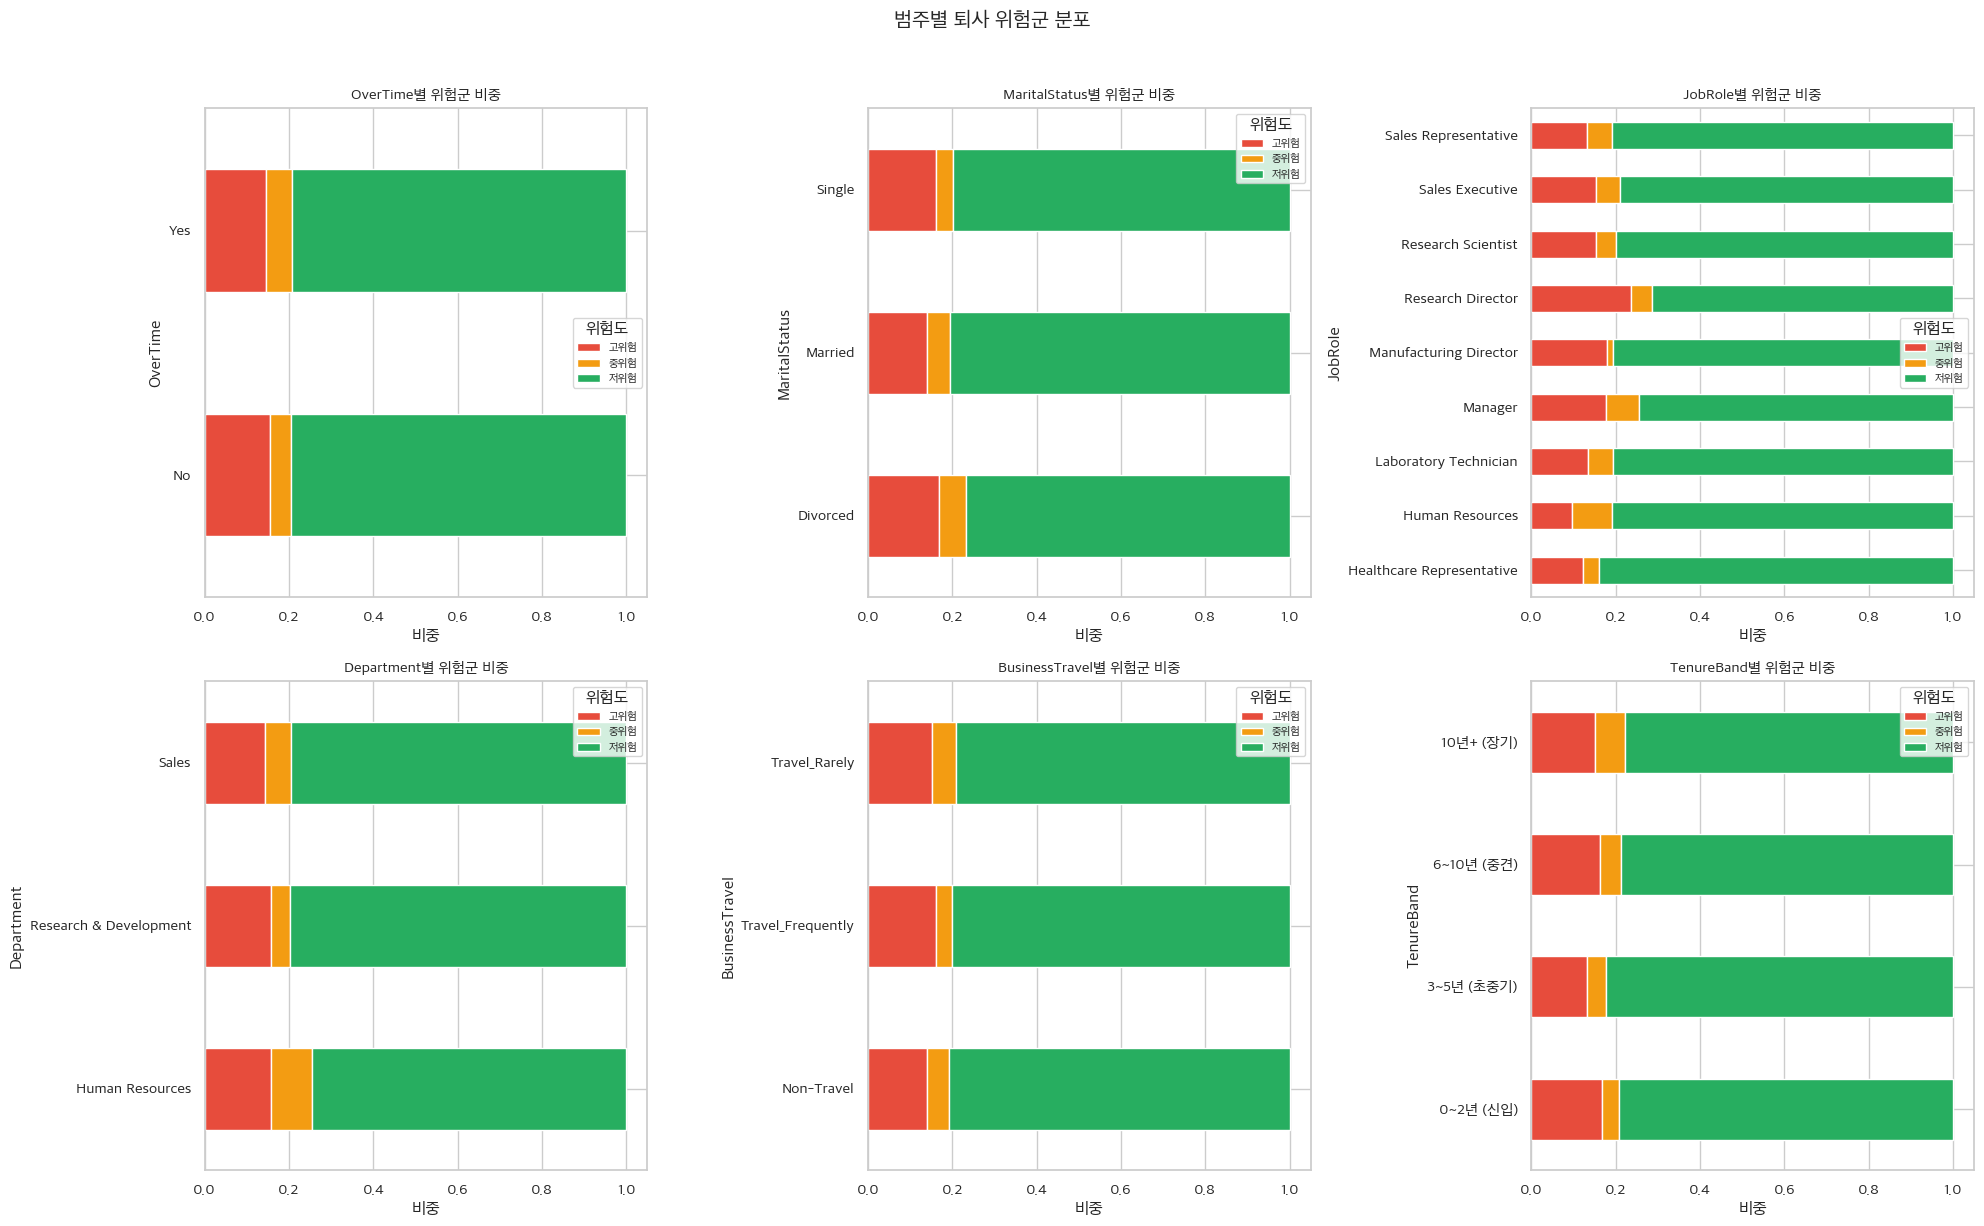

In [8]:
# 위험군별 범주형 변수 분포
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
cat_profile = ['OverTime', 'MaritalStatus', 'JobRole', 'Department',
               'BusinessTravel', 'TenureBand']

for i, col in enumerate(cat_profile):
    ax = axes[i // 3][i % 3]
    ct = pd.crosstab(raw[col], raw['Risk_Level'], normalize='index')
    # 고위험/중위험/저위험 순서로
    if '고위험' in ct.columns:
        order = [c for c in ['고위험', '중위험', '저위험'] if c in ct.columns]
        ct = ct[order]
    ct.plot(kind='barh', stacked=True, ax=ax,
            color=[COLORS_RISK.get(c, '#95A5A6') for c in ct.columns])
    ax.set_title(f'{col}별 위험군 비중', fontsize=11, fontweight='bold')
    ax.set_xlabel('비중')
    ax.legend(title='위험도', fontsize=8)

plt.suptitle('범주별 퇴사 위험군 분포', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../outputs/figures/17_risk_profile_categorical.png', dpi=150, bbox_inches='tight')
plt.show()

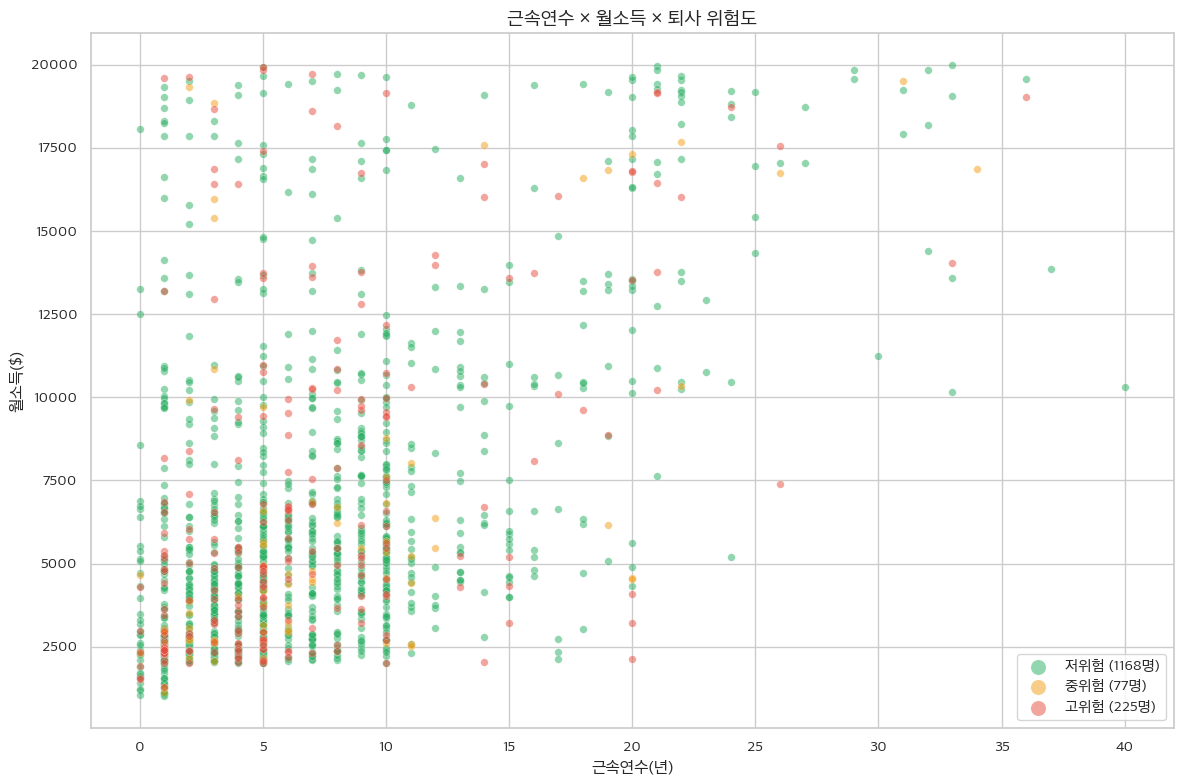

→ 고위험(빨강)이 좌하단(저소득 + 단기근속)에 집중
→ 리텐션 예산을 이 영역에 타깃팅해야 효율적


In [9]:
# 위험군 스캐터 플롯 — 소득 × 근속 × 위험도
fig, ax = plt.subplots(figsize=(12, 8))

for risk in ['저위험', '중위험', '고위험']:
    sub = raw[raw['Risk_Level'] == risk]
    ax.scatter(sub['YearsAtCompany'], sub['MonthlyIncome'],
               c=COLORS_RISK[risk], label=f'{risk} ({len(sub)}명)',
               alpha=0.5, s=30, edgecolors='white', linewidth=0.3)

ax.set_xlabel('근속연수(년)', fontsize=12)
ax.set_ylabel('월소득($)', fontsize=12)
ax.set_title('근속연수 × 월소득 × 퇴사 위험도', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, markerscale=2)

plt.tight_layout()
plt.savefig('../outputs/figures/18_risk_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

print("→ 고위험(빨강)이 좌하단(저소득 + 단기근속)에 집중")
print("→ 리텐션 예산을 이 영역에 타깃팅해야 효율적")

## 4.5 비용 영향 분석 & ROI 시뮬레이션

직원 1명의 대체비용을 **연봉의 100%**로 가정한다 (업계 표준: 50%~200%).

In [10]:
# 실제 퇴사자 비용 산출
attritors = raw[raw['Attrition'] == 'Yes']
annual_income = attritors['MonthlyIncome'] * 12

total_cost = annual_income.sum()
avg_cost = annual_income.mean()
n_attritors = len(attritors)

print("=" * 60)
print("현재 퇴사 비용 (연봉 100% 기준)")
print("=" * 60)
print(f"연간 퇴사자:     {n_attritors}명")
print(f"1인당 평균 비용:  ${avg_cost:,.0f}")
print(f"연간 총 비용:     ${total_cost:,.0f}")

# 위험군별 비용
print(f"\n위험군별 비용 분석:")
for risk in ['고위험', '중위험', '저위험']:
    sub = raw[(raw['Risk_Level'] == risk) & (raw['Attrition'] == 'Yes')]
    cost = (sub['MonthlyIncome'] * 12).sum()
    print(f"  {risk}: {len(sub):3d}명 퇴사, 비용 ${cost:>12,.0f}")

현재 퇴사 비용 (연봉 100% 기준)
연간 퇴사자:     237명
1인당 평균 비용:  $57,445
연간 총 비용:     $13,614,492

위험군별 비용 분석:
  고위험:  29명 퇴사, 비용 $   1,964,436
  중위험:   8명 퇴사, 비용 $     457,800
  저위험: 200명 퇴사, 비용 $  11,192,256


In [11]:
# 모델 개입 ROI 시뮬레이션
print("=" * 60)
print("모델 기반 개입 ROI 시뮬레이션")
print("=" * 60)

# 최종 모델 성능: Recall ~0.66
recall = 0.66

detected = int(n_attritors * recall)
missed = n_attritors - detected

print(f"\n모델 Recall={recall:.0%} 기준:")
print(f"  탐지 가능: {detected}명 / {n_attritors}명")
print(f"  놓침:      {missed}명")

scenarios = [
    ("보수적 (개입 성공률 20%)", 0.20),
    ("기본 (개입 성공률 30%)", 0.30),
    ("적극적 (개입 성공률 50%)", 0.50),
]

print(f"\n{'시나리오':<30s} {'리텐션 성공':>10s} {'절감 금액':>14s} {'연간 ROI':>10s}")
print("-" * 70)

intervention_cost = 200_000  # 연간 프로그램 운영비 추정

for label, success_rate in scenarios:
    retained = int(detected * success_rate)
    savings = retained * avg_cost
    roi = (savings - intervention_cost) / intervention_cost
    print(f"{label:<30s} {retained:>9d}명  ${savings:>12,.0f}  {roi:>9.1f}x")

print(f"\n(개입 프로그램 연간 운영비 $200,000 가정)")

모델 기반 개입 ROI 시뮬레이션

모델 Recall=66% 기준:
  탐지 가능: 156명 / 237명
  놓침:      81명

시나리오                               리텐션 성공          절감 금액     연간 ROI
----------------------------------------------------------------------
보수적 (개입 성공률 20%)                      31명  $   1,780,799        7.9x
기본 (개입 성공률 30%)                       46명  $   2,642,475       12.2x
적극적 (개입 성공률 50%)                      78명  $   4,480,719       21.4x

(개입 프로그램 연간 운영비 $200,000 가정)


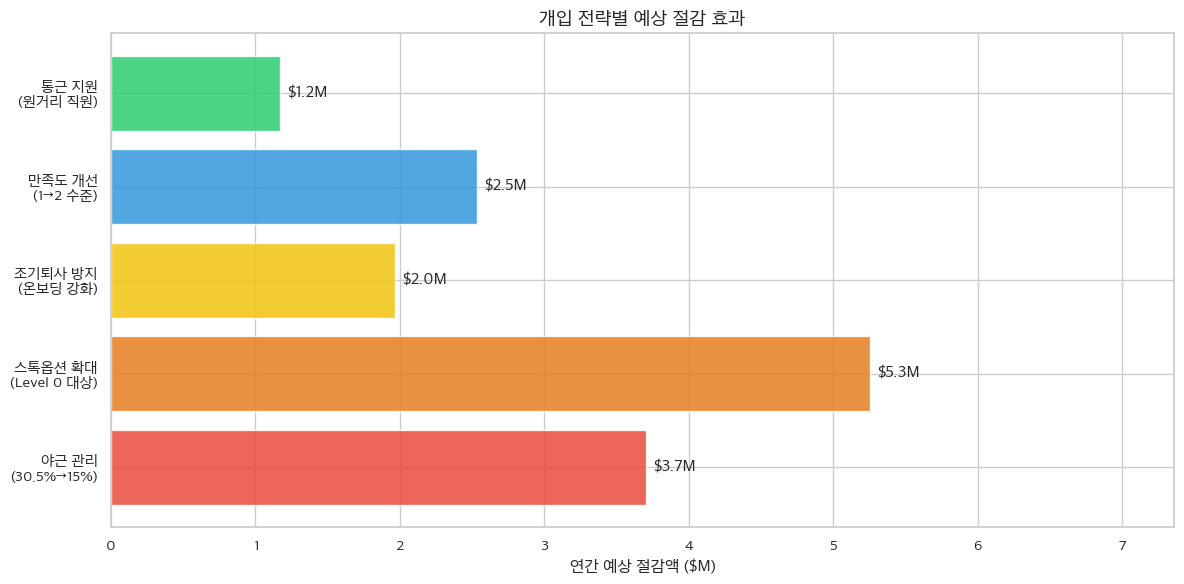

In [12]:
# 주요 개입별 절감 효과 시각화
fig, ax = plt.subplots(figsize=(12, 6))

interventions = {
    '야근 관리\n(30.5%→15%)': (raw['OverTime'] == 'Yes').sum() * 0.155 * avg_cost,
    '스톡옵션 확대\n(Level 0 대상)': (raw['StockOptionLevel'] == 0).sum() * 0.145 * avg_cost,
    '조기퇴사 방지\n(온보딩 강화)': len(raw[(raw['YearsAtCompany'] <= 2)]) * 0.10 * avg_cost,
    '만족도 개선\n(1→2 수준)': len(raw) * 0.03 * avg_cost,
    '통근 지원\n(원거리 직원)': len(raw[raw['DistanceFromHome'] > 20]) * 0.10 * avg_cost,
}

names = list(interventions.keys())
values = [v / 1_000_000 for v in interventions.values()]  # 백만달러 단위
colors = ['#E74C3C', '#E67E22', '#F1C40F', '#3498DB', '#2ECC71']

bars = ax.barh(names, values, color=colors, alpha=0.85)
for bar, val in zip(bars, values):
    ax.text(val + 0.05, bar.get_y() + bar.get_height()/2,
            f'${val:.1f}M', va='center', fontsize=12, fontweight='bold')

ax.set_xlabel('연간 예상 절감액 ($M)', fontsize=12)
ax.set_title('개입 전략별 예상 절감 효과', fontsize=14, fontweight='bold')
ax.set_xlim(0, max(values) * 1.4)

plt.tight_layout()
plt.savefig('../outputs/figures/19_intervention_savings.png', dpi=150, bbox_inches='tight')
plt.show()

## 4.6 부서별 맞춤 제언

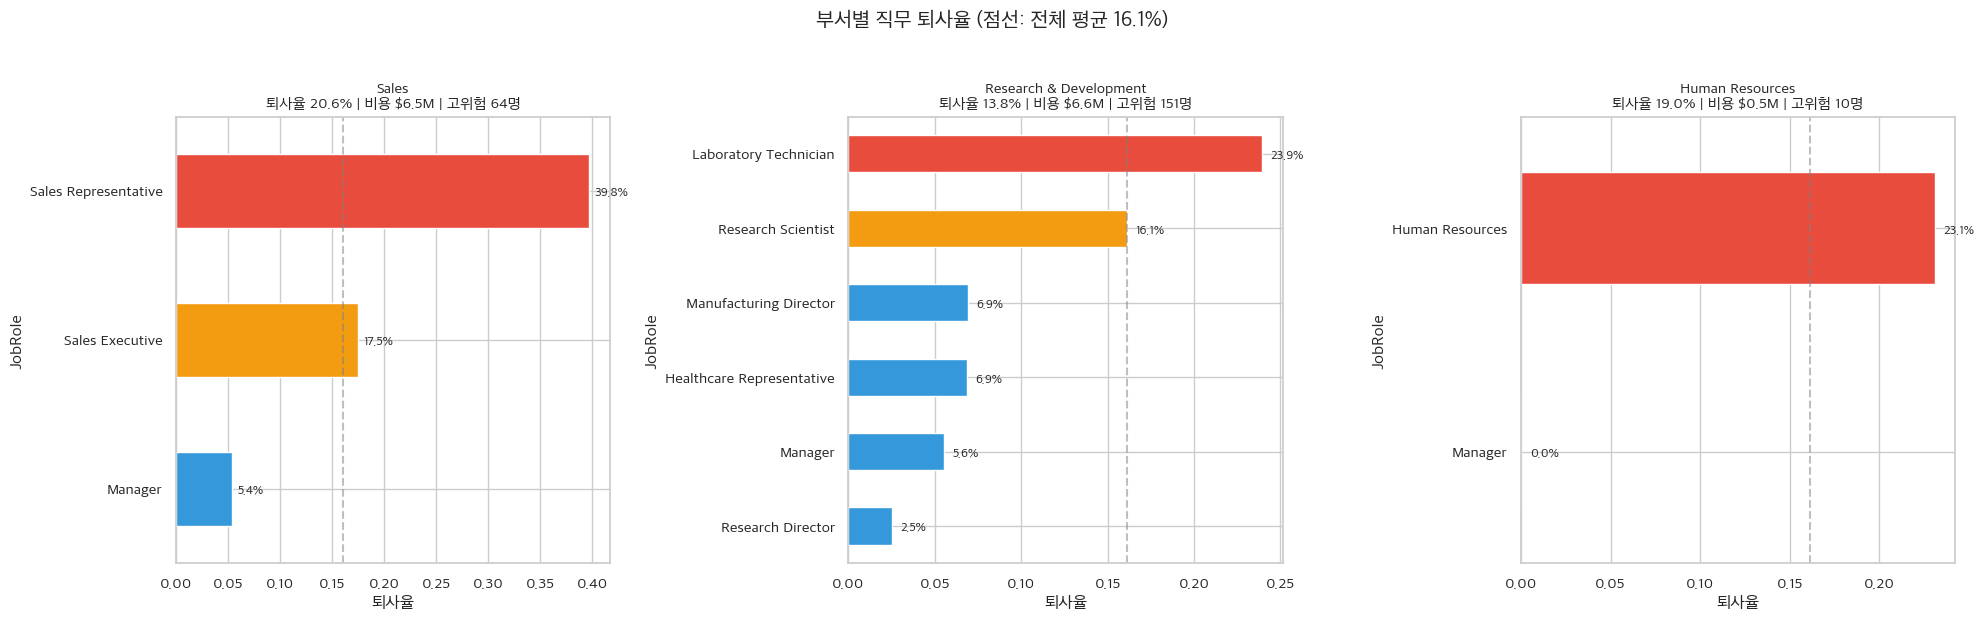

In [13]:
# 부서별 요약 대시보드
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, dept in enumerate(['Sales', 'Research & Development', 'Human Resources']):
    sub = raw[raw['Department'] == dept]
    sub_yes = sub[sub['Attrition'] == 'Yes']
    rate = len(sub_yes) / len(sub)
    avg_inc = sub_yes['MonthlyIncome'].mean() * 12 if len(sub_yes) > 0 else 0
    cost = (sub_yes['MonthlyIncome'] * 12).sum()
    high_risk = (sub['Risk_Level'] == '고위험').sum()

    # 직무별 퇴사율
    role_rates = sub.groupby('JobRole')['Attrition'].apply(
        lambda x: (x == 'Yes').mean()).sort_values(ascending=True)
    colors_r = ['#E74C3C' if r > 0.20 else '#F39C12' if r > 0.15 else '#3498DB'
                for r in role_rates]
    role_rates.plot(kind='barh', ax=axes[i], color=colors_r)
    axes[i].set_title(f'{dept}\n퇴사율 {rate:.1%} | 비용 ${cost/1e6:.1f}M | 고위험 {high_risk}명',
                      fontsize=11, fontweight='bold')
    axes[i].set_xlabel('퇴사율')
    axes[i].axvline(x=0.161, color='gray', linestyle='--', alpha=0.5)
    for j, (_, r) in enumerate(role_rates.items()):
        axes[i].text(r + 0.005, j, f'{r:.1%}', va='center', fontsize=9)

plt.suptitle('부서별 직무 퇴사율 (점선: 전체 평균 16.1%)', fontsize=15, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig('../outputs/figures/20_department_roles.png', dpi=150, bbox_inches='tight')
plt.show()

### 부서별 맞춤 전략

#### Sales (퇴사율 20.6%, 비용 $6.5M)
| 문제 | 제안 | 기대 효과 |
|------|------|----------|
| Sales Rep 퇴사율 39.8% | 성과급 구조 개편, 현실적 목표 설정 | 퇴사율 25%로 낮추면 ~12명 리텐션 |
| 잦은 출장으로 번아웃 | 출장 로테이션, 원격 영업 도구 도입 | 워라밸 개선 |
| SE 57명 퇴사 = $5.1M | 핵심인재 리텐션 보너스 | 10% 감소 시 $512K 절감 |

#### R&D (퇴사율 13.8%, 비용 $6.6M)
| 문제 | 제안 | 기대 효과 |
|------|------|----------|
| Lab Tech 퇴사율 23.9% | 기술직 커리어 패스 명확화 | 성장 비전으로 이탈 방지 |
| 연구 프로젝트 중단 리스크 | 지식 관리 시스템, 페어 연구 | 인수인계 비용 절감 |
| Level 3 고비용 퇴사 | 중간관리자 리더십 프로그램 | 핵심 경험자 리텐션 |

#### HR (퇴사율 19.0%, 비용 $535K)
| 문제 | 제안 | 기대 효과 |
|------|------|----------|
| 소규모이지만 높은 퇴사율 | 역할 재정의, 권한 확대 | 조직 내 HR 신뢰도 강화 |

## 4.7 실행 로드맵

### Phase 1: Quick Win (1~3개월)
- 야근 상위 20% 직원 대상 1:1 면담
- 퇴사 예측 모델 결과를 HR 시스템에 연동
- 고위험군 225명에 대한 즉시 리텐션 면담

### Phase 2: 구조적 개선 (3~6개월)
- 야근 관리 정책 수립 및 시행
- Level 1~2 대상 스톡옵션 프로그램
- 신입사원 90일 온보딩 프로그램 강화

### Phase 3: 문화 변화 (6~12개월)
- 분기별 만족도 펄스 서베이 도입
- Lab Tech, Sales Rep 커리어 패스 프로그램
- 데이터 기반 HR 대시보드 상시 운영

### 예상 종합 효과
| 항목 | 금액 |
|------|------|
| 현재 연간 퇴사 비용 | $13,614,492 |
| 예상 투자 (프로그램 운영) | ~$1,000,000 |
| 예상 절감 (보수적) | $3,000,000~$4,000,000 |
| **순 절감 / ROI** | **$2M~$3M / 약 3:1** |

## 4.8 한계점 및 향후 과제

### 데이터 한계
1. **횡단면 데이터**: 한 시점의 스냅샷으로, 시간에 따른 변화(만족도 추이, 소득 변화)를 반영하지 못함
2. **인과관계 미확인**: 야근이 퇴사를 유발하는지, 퇴사 의향이 있는 직원이 야근을 더 하는지 구분 불가
3. **합성 데이터 가능성**: IBM이 생성한 데이터로, 실제 기업 데이터와 패턴이 다를 수 있음
4. **외부 요인 부재**: 경기 상황, 경쟁사 채용, 산업 트렌드 미반영

### 모델 한계
1. **불균형 처리**: class_weight로 부분 해소했으나, 근본적 한계 존재
2. **해석 vs 성능 트레이드오프**: 트리 모델은 해석 용이하나 선형 모델 대비 Recall 낮음
3. **일반화**: 1,470명의 단일 데이터셋 학습 — 다른 기업에 직접 적용은 제한적

### 향후 과제
1. **SHAP 분석**: 개별 직원 수준의 퇴사 요인 해석
2. **시계열 확장**: 만족도 변화 추이를 반영한 동적 모델
3. **A/B 테스트**: 개입 프로그램의 실제 효과 측정
4. **텍스트 분석**: 퇴사 면담/설문 자유 응답 NLP 분석
5. **자사 데이터 적용**: 실제 기업 HRIS 데이터로 재학습